# Import libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from operator import itemgetter
import networkx as nx
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import scipy.stats
from math import sqrt
import statsmodels.formula.api as smf
from copy import deepcopy

# Import data

## Create network

In [2]:
G = nx.read_graphml('./london.graph.xml')

In [3]:
type(G)

networkx.classes.graph.Graph

In [4]:
# To check node attributes:
list(G.nodes(data = True))[0]

('Wembley Park', {'coords': '(519316.5590174915, 186389.32981656672)'})

In [5]:
#since coords tuples are stored as string, need to convert them back to tuples using eval()
for node in G.nodes():
    G.nodes[node]['coords'] = eval(G.nodes[node]['coords'])

In [6]:
# To check node attributes:
list(G.nodes(data = True))[0]

('Wembley Park', {'coords': (519316.5590174915, 186389.32981656672)})

In [7]:
# To check edges attributes:
list(G.edges(data = True))[0]

('Wembley Park',
 'Kingsbury',
 {'length': 2916.7715580506483, 'line_name': 'Jubilee', 'flows': 12356})

In [8]:
original_nodes = set(G.nodes())

isolated = list(nx.isolates(G))
G.remove_nodes_from(isolated)

updated_nodes = set(G.nodes())

removed_nodes = original_nodes - updated_nodes

print("Removed nodes:", removed_nodes)

Removed nodes: set()


In [9]:
extra_edges_removed = []

for u, v in list(G.edges()):
    if G.number_of_edges(u, v) > 1:
        extra_edges = list(G.edges(u, v))[1:]
        extra_edges_removed.extend(extra_edges)
        G.remove_edges_from(extra_edges) 

print("Removed extra edges:", extra_edges_removed)

Removed extra edges: []


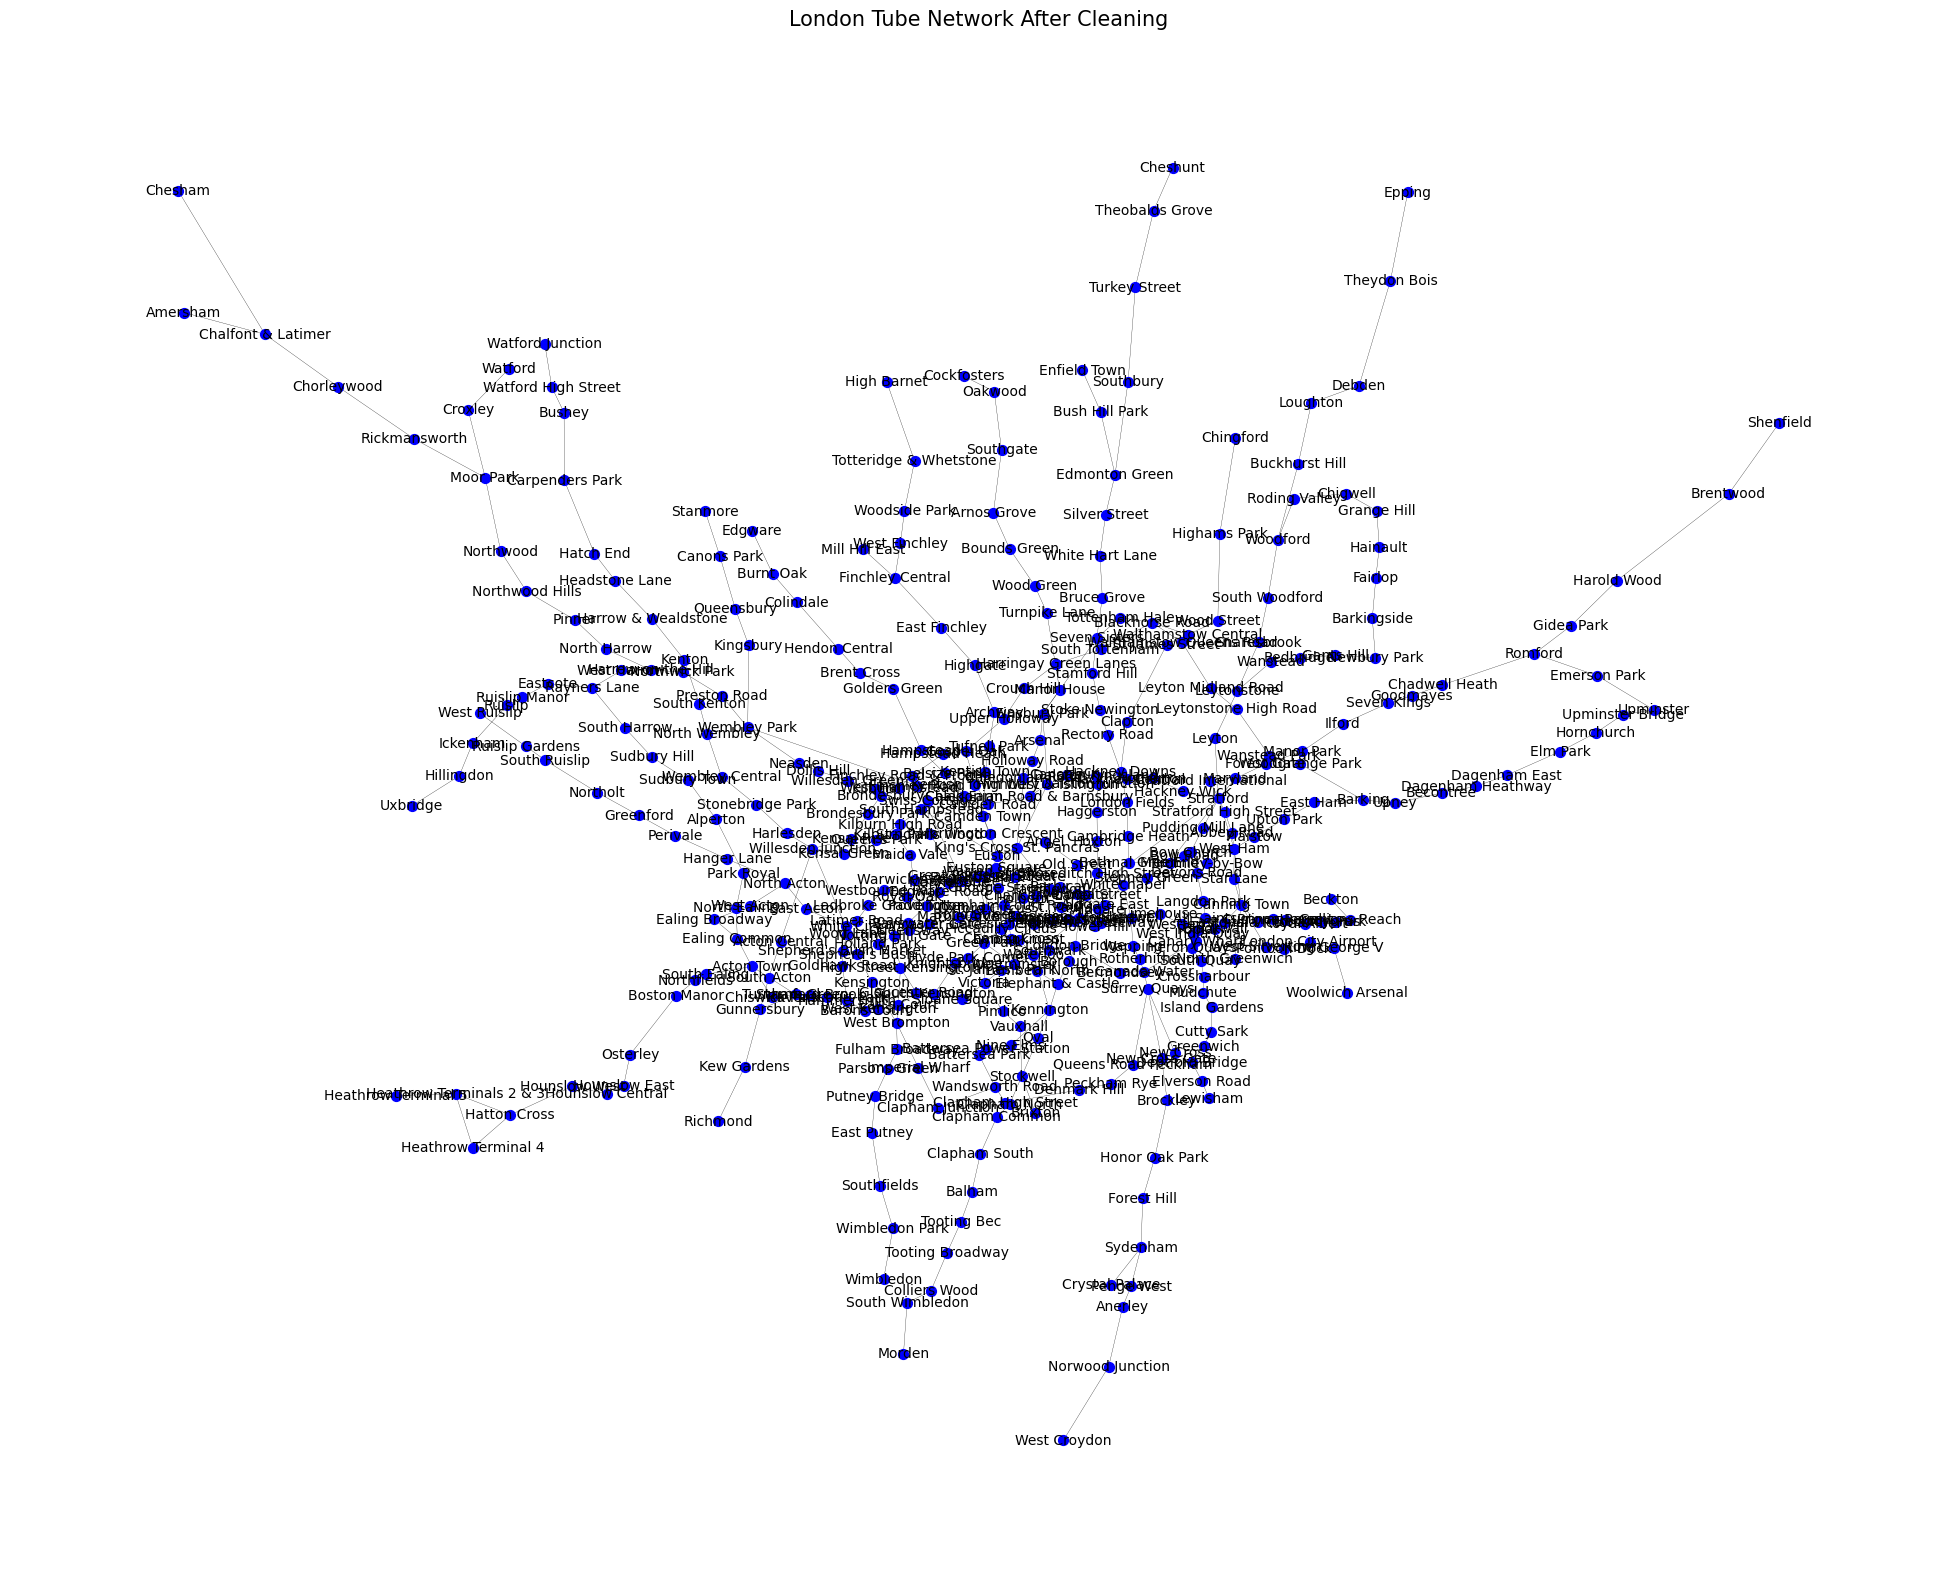

In [10]:
fig, ax = plt.subplots(figsize=(25,20))

node_labels = {node: node for node in G.nodes()} 

pos = nx.get_node_attributes(G, 'coords')

nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue')
nx.draw_networkx_edges(G, pos, arrows=False, width=0.2)
nx.draw_networkx_labels(G, pos, node_labels, font_size=10, font_color='black')

plt.title("London Tube Network After Cleaning", fontsize=15)
plt.axis("off")
plt.show()

In [11]:
# We can print the dataframe from the shapefile to check the data
df = nx.to_pandas_edgelist(G)
df

,source,target,length,line_name,flows
0,Wembley Park,Kingsbury,2916.771558,Jubilee,12356
1,Wembley Park,Neasden,2353.165938,Jubilee,6744
2,Wembley Park,Preston Road,1419.735166,Metropolitan,36601
3,Wembley Park,Finchley Road,7266.373927,Metropolitan,55216
4,Kingsbury,Queensbury,1245.995234,Jubilee,9419
...,...,...,...,...,...
462,Hounslow Central,Hounslow East,745.684383,Piccadilly,13469
463,Hounslow East,Osterley,967.494672,Piccadilly,15935
464,Osterley,Boston Manor,2560.814291,Piccadilly,17445
465,Boston Manor,Northfields,930.852145,Piccadilly,18598


In [12]:
# 设置起始站名称，假设为'StationA'
start_station = 'Ealing Broadway'

# 筛选出所有起始站为'StationA'的行
filtered_df = df[df['source'] == start_station]

# 查看筛选结果
print(filtered_df)

             source         target       length line_name  flows
71  Ealing Broadway  Ealing Common  1565.297083  District  10022


## Import csv

In [13]:
df_od = pd.read_csv('london_flows.csv')

df_od.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [14]:
df_od.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61474 entries, 0 to 61473
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       61474 non-null  object 
 1   station_destination  61474 non-null  object 
 2   flows                61474 non-null  int64  
 3   population           61474 non-null  int64  
 4   jobs                 61474 non-null  int64  
 5   distance             61474 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 2.8+ MB


In [15]:
missing_colum = df_od.isnull().sum()
print("Missing values per column:")
print(missing_colum)

total_missing = missing_colum.sum()
print("Total missing values in the dataset:", total_missing)

if total_missing > 0:
    print("Rows with missing values:")
    print(df_od[df_od.isnull().any(axis=1)])

Missing values per column:
station_origin         0
station_destination    0
flows                  0
population             0
jobs                   0
distance               0
dtype: int64
Total missing values in the dataset: 0


In [16]:
G_w = G.copy()

In [17]:
line_names = set()
for u, v, data in G_w.edges(data=True):
    if 'line_name' in data:
        line_names.add(data['line_name'])

line_names = sorted(line_names, key=str.lower)

print(line_names)

['Bakerloo', 'Central', 'Circle', 'District', 'DLR', 'Hammersmith & City', 'Jubilee', 'London Overground', 'Metropolitan', 'Northern', 'Piccadilly', 'TfL Rail', 'Victoria', 'Waterloo & City']


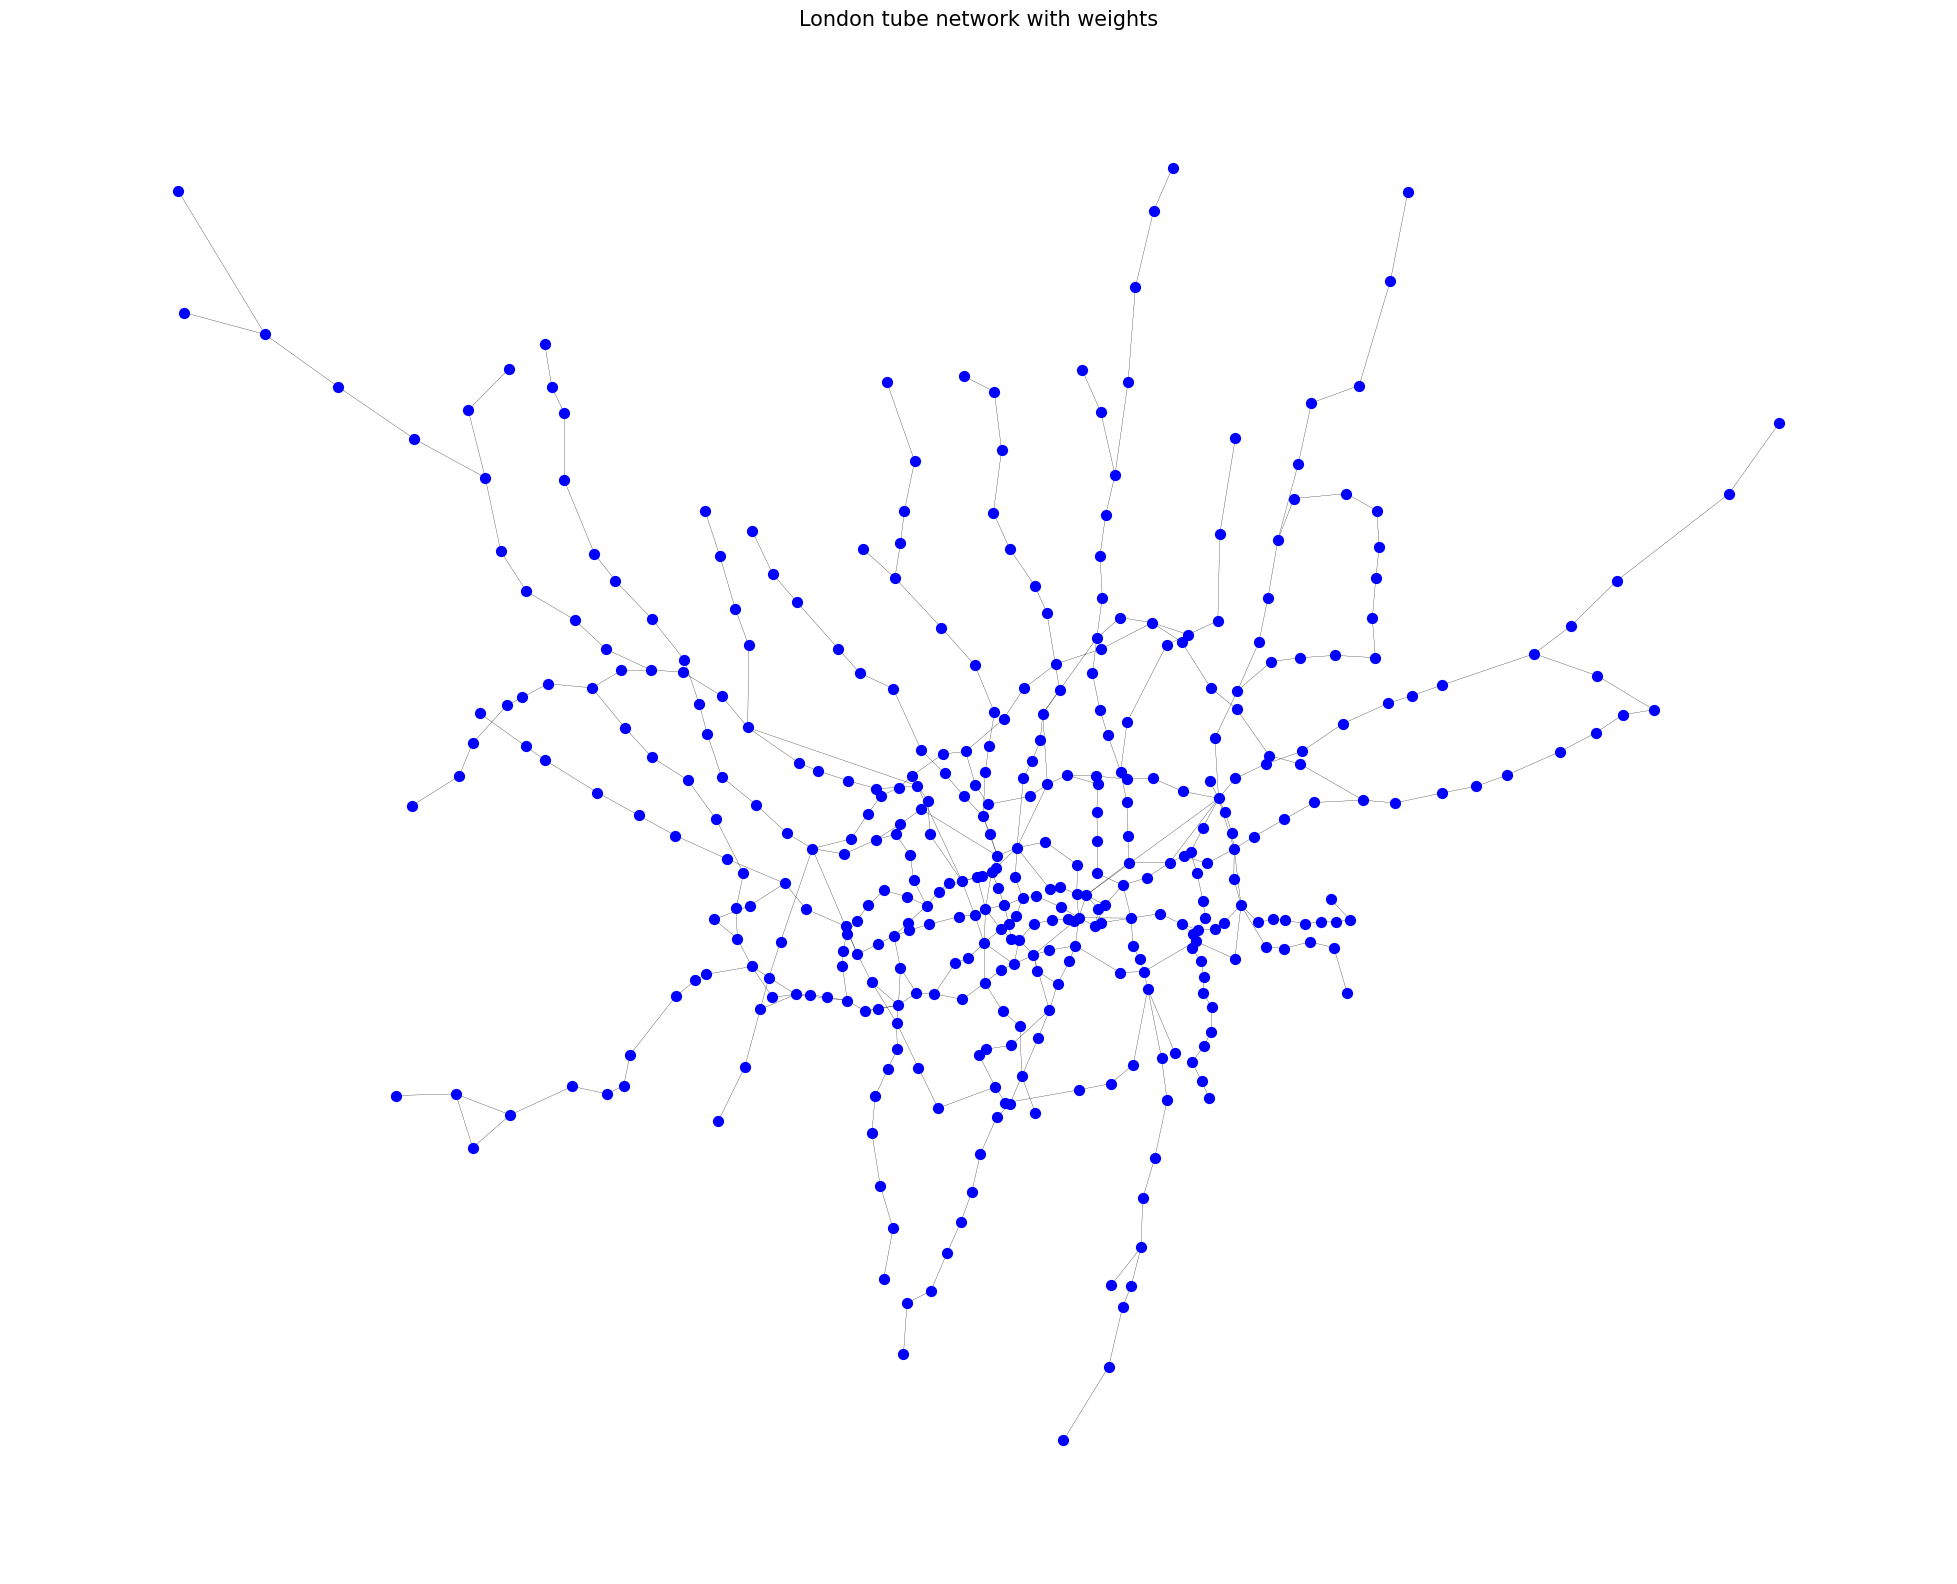

In [18]:
fig, ax = plt.subplots(figsize=(25,20))

node_labels = {node: node for node in G_w.nodes()} 

pos = nx.get_node_attributes(G_w, 'coords') 

nx.draw_networkx_nodes(G_w, pos, node_size=50, node_color='b')
nx.draw_networkx_edges(G_w, pos, arrows=False, width=0.2)

plt.title("London tube network with weights", fontsize=15)
plt.axis("off")
plt.show()

## Merge

In [19]:
df_od_w = df_od.copy()

In [20]:
od_names = set(df_od_w.station_origin.unique())
network_names = set([n for n in G_w.nodes()])

In [21]:
network_names.symmetric_difference(od_names)

{'Battersea Power Station', 'Nine Elms'}

In [27]:
missing_in_network = [name for name in ['Battersea Power Station', 'Nine Elms'] if name not in network_names]
if missing_in_network:
    print("The following stations do not exist in the network data:", missing_in_network)
else:
    print("All listed stations exist in the network data.")

All listed stations exist in the network data.


In [28]:
missing_in_od = [name for name in ['Battersea Power Station', 'Nine Elms'] if name not in od_names]
if missing_in_od:
    print("The following stations do not exist in the flows data:", missing_in_od)
else:
    print("All listed stations exist in the flows data.")

The following stations do not exist in the flows data: ['Battersea Power Station', 'Nine Elms']


In [22]:
node_list = set(G_w.nodes())
no_data_nodes = node_list.difference(set(df_od_w['station_origin'].unique()).union(set(df_od_w['station_destination'].unique())))
print(no_data_nodes)

{'Battersea Power Station', 'Nine Elms'}


In [23]:
pseudo_flows = pd.DataFrame({
    'station_origin': list(node_list),
    'station_destination': list(node_list),
    'flows': [0.001] * len(node_list) 
})
df_od_w = pd.concat([df_od_w, pseudo_flows], ignore_index=True)

In [24]:
df_od_w['flows_w'] = df_od_w ['flows'].replace(0, 0.001)

In [25]:
stations_to_check = ['Nine Elms', 'Battersea Power Station']

results = df_od_w[(df_od_w['station_origin'].isin(stations_to_check)) |
                  (df_od_w['station_destination'].isin(stations_to_check))]

results

,station_origin,station_destination,flows,population,jobs,distance,flows_w
61715,Nine Elms,Nine Elms,0.001,NaN,NaN,NaN,0.001
61748,Battersea Power Station,Battersea Power Station,0.001,NaN,NaN,NaN,0.001


In [26]:
df_od_w.head(10)

,station_origin,station_destination,flows,population,jobs,distance,flows_w
0,Abbey Road,Bank and Monument,0.0,599.0,78549.0,8131.525097,0.001
1,Abbey Road,Beckton,1.0,599.0,442.0,8510.121774,1.000
2,Abbey Road,Blackwall,3.0,599.0,665.0,3775.448872,3.000
3,Abbey Road,Canary Wharf,1.0,599.0,58772.0,5086.514220,1.000
4,Abbey Road,Canning Town,37.0,599.0,15428.0,2228.923167,37.000
5,Abbey Road,Crossharbour,1.0,599.0,1208.0,6686.475560,1.000
6,Abbey Road,Custom House,0.0,599.0,845.0,3824.855630,0.001
7,Abbey Road,Cutty Sark,2.0,599.0,1748.0,8503.898909,2.000
8,Abbey Road,Cyprus,7.0,599.0,850.0,6532.099618,7.000
9,Abbey Road,Devons Road,1.0,599.0,611.0,3958.324171,1.000


## Flows: weighted network

In [27]:
#create a dictionary to store flows for all edges
flows_w = {(u,v): 0 for u,v in G_w.edges()}

In [28]:
for i, row in df_od_w.iterrows():
    source = row.station_origin
    target = row.station_destination
    
    #get shortest path
    path = nx.dijkstra_path(G_w, source, target)
    
    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    #add flows to our dict
    for u,v in path_edges:
        try:
            flows_w[(u,v)] += row.flows_w
        except:
            flows_w[(v,u)] += row.flows_w

In [29]:
nx.set_edge_attributes(G_w, flows_w, 'flows_w')

In [30]:
# 检查是否还存在为零的流量值
zero_flows = any(d['flows_w'] == 0 for _, _, d in G_w.edges(data=True))
if zero_flows:
    print("have 0.")
else:
    print("no 0.")

have 0.


In [31]:
for u, v, d in G_w.edges(data=True):
    if d['flows_w'] == 0:
        print(f"Edge ({u}, {v}) has zero flow.")
        G_w[u][v]['flows_w'] = 0.001

Edge (Kennington, Nine Elms) has zero flow.
Edge (Battersea Power Station, Nine Elms) has zero flow.


In [32]:
zero_flows = any(d['flows_w'] == 0 for _, _, d in G_w.edges(data=True))
if zero_flows:
    print("have 0.")
else:
    print("no 0.")

no 0.


In [33]:
u, v = list(G_w.edges())[0] 
print("Edge:", u, v, "flows_w:", G_w[u][v]['flows_w'])

Edge: Wembley Park Kingsbury flows_w: 12356.546000000093


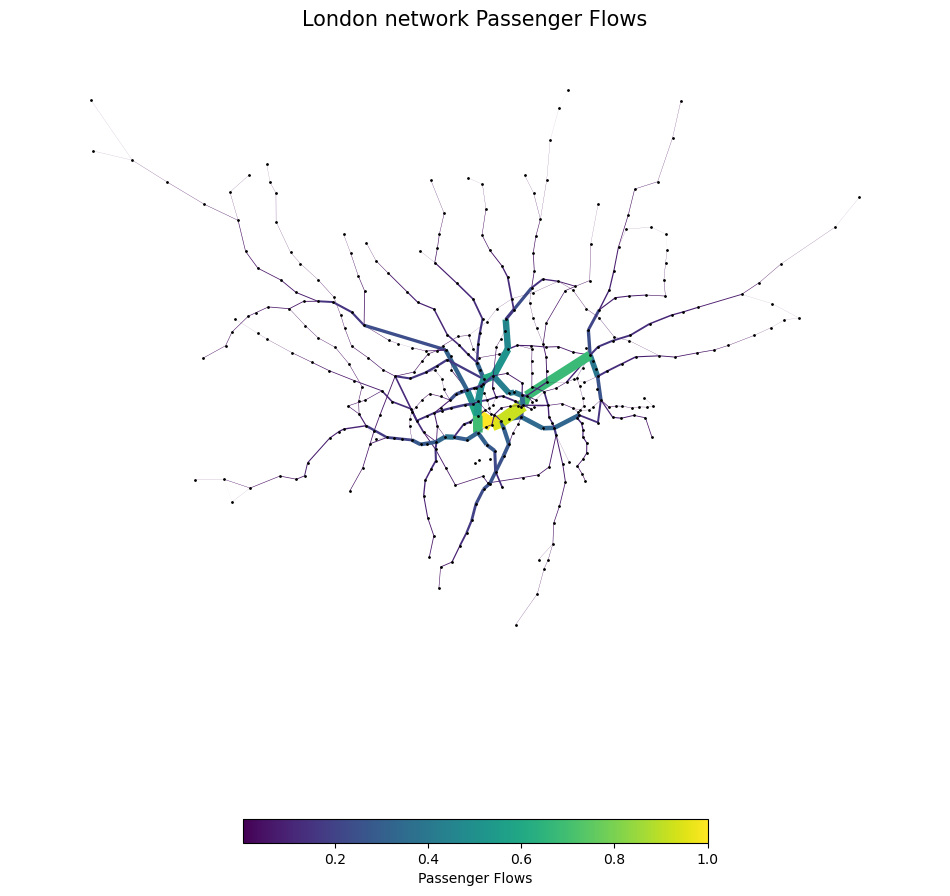

In [34]:
flows_values = flows_w.values()
flow_color = [(i[2]['flows_w']/max(flows_values)) for i in G_w.edges(data=True)]
flow_width = [(i[2]['flows_w']/max(flows_values)*10) for i in G_w.edges(data=True)]

fig, ax = plt.subplots(figsize=(12,12))

edg = nx.draw_networkx_edges(G_w, pos, edge_color=flow_color, width=flow_width)

nx.draw_networkx_nodes(G_w,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London network Passenger Flows",fontsize=15)
plt.show()

# Weighted centrality measures

## Deg_w

In [35]:
def compute_weighted_degree_centrality(G):
    deg_w_dict = {}
    for node in G.nodes():
       
        deg_w = sum(data['flows_w'] for _, _, data in G.edges(node, data=True))
        deg_w_dict[node] = deg_w

    max_deg_w = max(deg_w_dict.values()) if deg_w_dict else 0
    if max_deg_w > 0:
        deg_w_dict = {k: v / max_deg_w for k, v in deg_w_dict.items()}
    return deg_w_dict

deg_w_scores = compute_weighted_degree_centrality(G_w)

df_deg_w = pd.DataFrame(list(deg_w_scores.items()), columns=['Node', 'degree_w'])
df_deg_w_sorted = df_deg_w.sort_values(by='degree_w', ascending=False)
df_deg_w_sorted.head(10)

,Node,degree_w
16,Green Park,1.000000
50,Bank and Monument,0.853323
14,Waterloo,0.833009
15,Westminster,0.670993
229,King's Cross St. Pancras,0.623424
51,Liverpool Street,0.565904
5,Stratford,0.539138
150,Euston,0.514957
17,Bond Street,0.449339
204,Victoria,0.430910


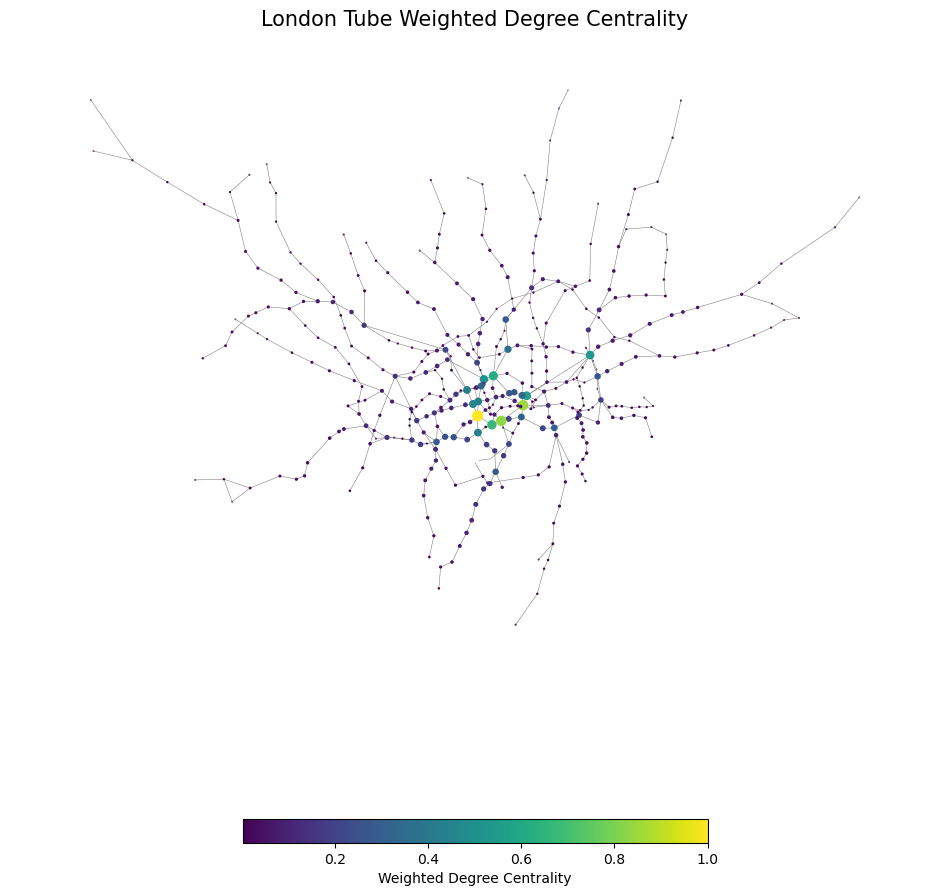

In [36]:
max_degree_w = df_deg_w['degree_w'].max()
deg_w_london_values = df_deg_w['degree_w'].tolist()

deg_w_london_color = [deg / max_degree_w for deg in deg_w_london_values]
deg_w_london_size = [(deg / max_degree_w) * 50 for deg in deg_w_london_values]  

pos = nx.get_node_attributes(G_w, 'coords') 

fig, ax = plt.subplots(figsize=(12, 12))

nx.draw_networkx_edges(G_w, pos, edge_color='gray', width=0.4)
nod = nx.draw_networkx_nodes(G_w,
                             pos=pos,
                             node_color=deg_w_london_color,
                             node_size=deg_w_london_size,
                             cmap=plt.cm.viridis)

plt.colorbar(nod, label="Weighted Degree Centrality", orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London Tube Weighted Degree Centrality", fontsize=15)
plt.show()

## Clo_w

In [37]:
clos_w=nx.closeness_centrality(G_w, distance='flows_w')
# We can add these values to the nodes attributes:
nx.set_node_attributes(G_w,clos_w,'closeness_w')

# To ataframe using the nodes as the index
df_clo_w = pd.DataFrame(index=G_w.nodes())
df_clo_w ['closeness_w'] = pd.Series(nx.get_node_attributes(G_w, 'closeness_w'))

df_clo_w_sorted = df_clo_w.sort_values(["closeness_w"], ascending=False)
pd.set_option('display.float_format', '{:.8f}'.format)
df_clo_w_sorted[0:10]

,closeness_w
West Hampstead,0.00000619
Finchley Road & Frognal,0.00000612
Hampstead Heath,0.00000606
Brondesbury,0.00000603
Gospel Oak,0.00000602
Upper Holloway,0.00000600
Crouch Hill,0.00000597
Harringay Green Lanes,0.00000594
Leicester Square,0.00000592
Piccadilly Circus,0.00000592


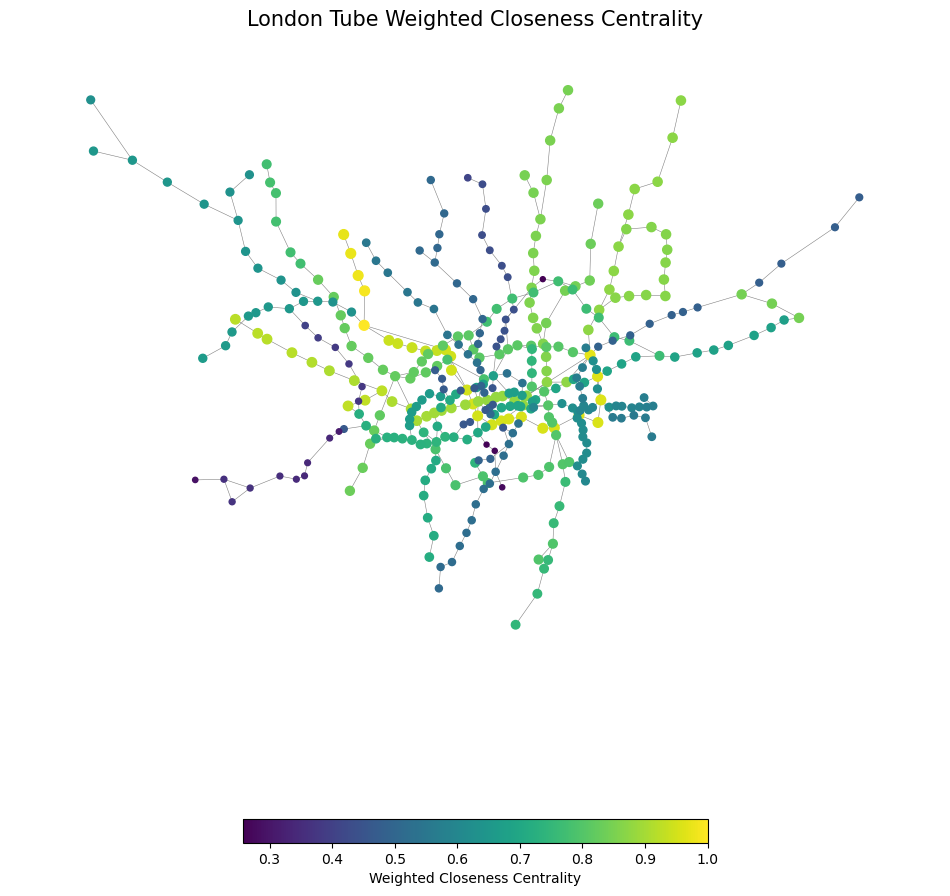

In [38]:
closeness_w_values = df_clo_w_sorted['closeness_w'].tolist()
max_closeness_w = max(closeness_w_values)

# Normalize based on the maximum value for color and size
closeness_w_color = [closeness / max_closeness_w for closeness in closeness_w_values]
closeness_w_size = [(closeness / max_closeness_w) * 50 for closeness in closeness_w_values]  # Scaling size

# Plotting the graph
fig, ax = plt.subplots(figsize=(12, 12))

nx.draw_networkx_edges(G_w, pos, edge_color='gray', width=0.4)
nod_clo = nx.draw_networkx_nodes(G_w,
                                 pos=pos,
                                 node_color=closeness_w_color,
                                 node_size=closeness_w_size,
                                 cmap=plt.cm.viridis)

plt.colorbar(nod_clo, label="Weighted Closeness Centrality", orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London Tube Weighted Closeness Centrality", fontsize=15)
plt.show()

## Bet_w

In [39]:
bet_w = nx.betweenness_centrality(G_w, weight='flows_w', normalized=False)

nx.set_node_attributes(G_w, bet_w, 'betweenness_w')

df_bet_w = pd.DataFrame(list(bet_w.items()), columns=['Node', 'betweenness_w'])

df_bet_w_sorted = df_bet_w.sort_values(by='betweenness_w', ascending=False)

df_bet_w_sorted.head(10)

,Node,betweenness_w
26,West Hampstead,27973.00000000
121,Gospel Oak,21839.00000000
119,Finchley Road & Frognal,21336.00000000
120,Hampstead Heath,21253.00000000
6,West Ham,20875.00000000
343,Leicester Square,20084.00000000
161,Blackhorse Road,19090.00000000
157,Upper Holloway,18302.00000000
158,Crouch Hill,18175.00000000
111,Willesden Junction,18134.00000000


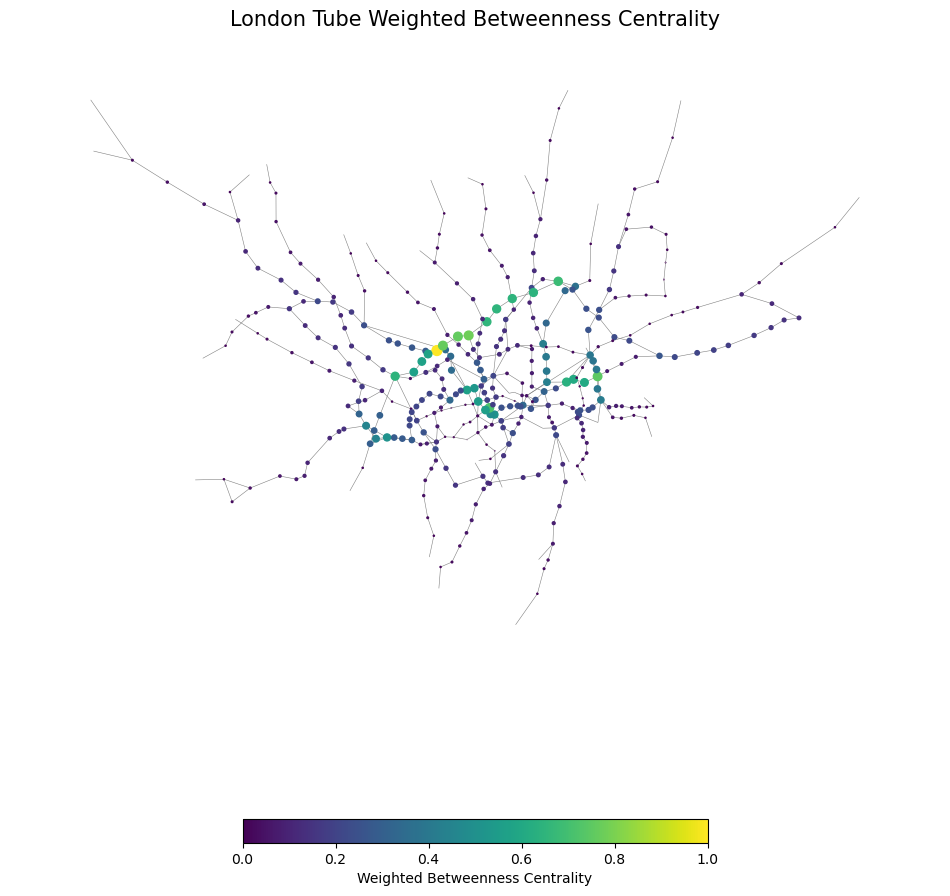

In [40]:
max_betweenness_w = df_bet_w['betweenness_w'].max()
betweenness_w_values = df_bet_w['betweenness_w'].tolist()

betweenness_w_color = [bet / max_betweenness_w for bet in betweenness_w_values]
betweenness_w_size = [(bet / max_betweenness_w) * 50 for bet in betweenness_w_values]  

fig, ax = plt.subplots(figsize=(12, 12))

nx.draw_networkx_edges(G_w, pos, edge_color='gray', width=0.4)
nod_bet = nx.draw_networkx_nodes(G_w,
                                 pos=pos,
                                 node_color=betweenness_w_color,
                                 node_size=betweenness_w_size,
                                 cmap=plt.cm.viridis)

plt.colorbar(nod_bet, label="Weighted Betweenness Centrality", orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London Tube Weighted Betweenness Centrality", fontsize=15)
plt.show()

# Weighted Impact Measures

### WE

In [41]:
original_n = len(G_w) 

for u, v, d in G_w.edges(data=True):
    d['weight'] = d['flows_w'] 

def calculate_network_efficiency(G, original_n):
    n = original_n
    sum_of_inverse_shortest_paths = 0.0
    all_pairs = nx.all_pairs_dijkstra_path_length(G, weight='weight')

    for source, path_lengths in all_pairs:
        for target, length in path_lengths.items():
            if source != target:
                sum_of_inverse_shortest_paths += 1 / length

    if n > 1:
        efficiency = sum_of_inverse_shortest_paths / (n * (n - 1))
    else:
        efficiency = 0

    return efficiency

network_efficiency = calculate_network_efficiency(G_w, original_n)
print("The network efficiency is:", network_efficiency)

The network efficiency is: 0.03147287969964882


### PFL

In [42]:
def calculate_total_flow(G):
    total_flow = sum(data['flows_w'] for u, v, data in G.edges(data=True))
    return total_flow

total_flow_original = calculate_total_flow(G_w)
print("Total flow in the original network:", total_flow_original)

Total flow in the original network: 9931082.630999919


# Node removal

## Best centrality fromⅠ

top 3 from bet：Stratford，Bank and Monument，Liverpool Street

### 1

In [43]:
G_w_1 = deepcopy(G_w)

for u, v, d in G_w_1.edges(data=True):
    d['weight'] = d['flows_w']  # 

G_w_1.remove_node('Stratford')

def calculate_efficiency(G, original_n):
    all_pairs_shortest_path_length = dict(nx.all_pairs_dijkstra_path_length(G, weight='weight'))
    total_efficiency = 0
    count_valid_pairs = 0

    for source in all_pairs_shortest_path_length:
        for target in all_pairs_shortest_path_length[source]:
            if source != target:
                path_length = all_pairs_shortest_path_length[source][target]
                if path_length < float('inf'): 
                    total_efficiency += 1 / path_length
                    count_valid_pairs += 1

    if count_valid_pairs > 0:
        average_efficiency = total_efficiency / (original_n * (original_n - 1))
    else:
        average_efficiency = 0

    return average_efficiency

network_efficiency = calculate_efficiency(G_w_1, original_n)
print("Modified network efficiency:", network_efficiency)

Modified network efficiency: 0.03147232270236411


In [44]:
for u, v, d in G_w_1.edges(data=True):
    d['weight'] = d['flows_w']
    
def calculate_total_flow(G):
    total_flow = sum(data['flows_w'] for u, v, data in G.edges(data=True))
    return total_flow

total_flow_original = calculate_total_flow(G_w) 
print("Total flow in the original network:", total_flow_original)

total_flow_remaining = calculate_total_flow(G_w_1)
print("Remaining flow in the network after node removal:", total_flow_remaining)

flow_loss = total_flow_original - total_flow_remaining
print("Flow loss due to node removal:", flow_loss)

Total flow in the original network: 9931082.630999919
Remaining flow in the network after node removal: 9542972.43399993
Flow loss due to node removal: 388110.19699998945


### 2

In [45]:
for u, v, d in G_w_1.edges(data=True):
    d['weight'] = d['flows_w'] 
    
G_w_1.remove_node('Bank and Monument')

def calculate_efficiency(G, original_n):
    all_pairs_shortest_path_length = dict(nx.all_pairs_dijkstra_path_length(G, weight='weight'))
    total_efficiency = 0
    count_valid_pairs = 0

    for source in all_pairs_shortest_path_length:
        for target in all_pairs_shortest_path_length[source]:
            if source != target:
                path_length = all_pairs_shortest_path_length[source][target]
                if path_length < float('inf'):
                    total_efficiency += 1 / path_length
                    count_valid_pairs += 1

    if count_valid_pairs > 0:
        average_efficiency = total_efficiency / (original_n * (original_n - 1))
    else:
        average_efficiency = 0

    return average_efficiency

network_efficiency = calculate_efficiency(G_w_1, original_n)
print("Modified network efficiency after removing 'Bank and Monument':", network_efficiency)

Modified network efficiency after removing 'Bank and Monument': 0.03147219404437063


In [47]:
for u, v, d in G_w_1.edges(data=True):
    d['weight'] = d['flows_w'] 

def calculate_total_flow(G):
    total_flow = sum(data['flows_w'] for u, v, data in G.edges(data=True))
    return total_flow

total_flow_original = calculate_total_flow(G_w)
print("Total flow in the original network:", total_flow_original)

total_flow_remaining = calculate_total_flow(G_w_1)
print("Remaining flow in the network after removing 'Bank and Monument':", total_flow_remaining)

flow_loss = total_flow_original - total_flow_remaining
print("Flow loss due to removing 'Bank and Monument':", flow_loss)

Total flow in the original network: 9931082.630999919
Remaining flow in the network after removing 'Bank and Monument': 8928689.28999994
Flow loss due to removing 'Bank and Monument': 1002393.3409999795


### 3

In [48]:
for u, v, d in G_w_1.edges(data=True):
    d['weight'] = d['flows_w']

G_w_1.remove_node('Liverpool Street')

def calculate_efficiency(G, original_n):
    all_pairs_shortest_path_length = dict(nx.all_pairs_dijkstra_path_length(G, weight='weight'))
    total_efficiency = 0
    count_valid_pairs = 0

    for source in all_pairs_shortest_path_length:
        for target in all_pairs_shortest_path_length[source]:
            if source != target:
                path_length = all_pairs_shortest_path_length[source][target]
                if path_length < float('inf'): 
                    total_efficiency += 1 / path_length
                    count_valid_pairs += 1

    if count_valid_pairs > 0:
        average_efficiency = total_efficiency / (original_n * (original_n - 1))
    else:
        average_efficiency = 0

    return average_efficiency

network_efficiency = calculate_efficiency(G_w_1, original_n)
print("Modified network efficiency after removing 'Liverpool Street':", network_efficiency)

Modified network efficiency after removing 'Liverpool Street': 0.031472125613933144


In [49]:
for u, v, d in G_w_1.edges(data=True):
    d['weight'] = d['flows_w'] 
    
def calculate_total_flow(G):
    total_flow = sum(data['flows_w'] for u, v, data in G.edges(data=True))
    return total_flow

total_flow_original = calculate_total_flow(G_w)
print("Total flow in the original network:", total_flow_original)

total_flow_remaining = calculate_total_flow(G_w_1)
print("Remaining flow in the network after removing 'Liverpool Street':", total_flow_remaining)

flow_loss = total_flow_original - total_flow_remaining
print("Flow loss due to removing 'Liverpool Street':", flow_loss)

Total flow in the original network: 9931082.630999919
Remaining flow in the network after removing 'Liverpool Street': 8842894.74899994
Flow loss due to removing 'Liverpool Street': 1088187.8819999788


## Strategy B

### B - deg_w

In [50]:
G_w_deg_b = deepcopy(G_w)

#### 1

In [51]:
G_w_deg_b.remove_node('Green Park')

In [52]:
for u, v, d in G_w_deg_b.edges(data=True):
    d['weight'] = d['flows_w'] 
    
def calculate_efficiency(G, original_n):
    all_pairs_shortest_path_length = dict(nx.all_pairs_dijkstra_path_length(G, weight='weight'))
    total_efficiency = 0
    count_valid_pairs = 0

    for source in all_pairs_shortest_path_length:
        for target in all_pairs_shortest_path_length[source]:
            if source != target:
                path_length = all_pairs_shortest_path_length[source][target]
                if path_length < float('inf'):
                    total_efficiency += 1 / path_length
                    count_valid_pairs += 1

    if count_valid_pairs > 0:
        average_efficiency = total_efficiency / (original_n * (original_n - 1))
    else:
        average_efficiency = 0
    return average_efficiency

def calculate_total_flow(G):
    total_flow = sum(data['weight'] for _, _, data in G.edges(data=True) if 'weight' in data)
    return total_flow

original_n = len(G_w)
total_flow_original = calculate_total_flow(G_w)
network_efficiency = calculate_efficiency(G_w_deg_b, original_n) 
total_flow_remaining = calculate_total_flow(G_w_deg_b)

flow_loss = total_flow_original - total_flow_remaining

print("Modified network efficiency after removing 'Green Park':", network_efficiency)
print("Flow loss due to removing 'Green Park':", flow_loss)

Modified network efficiency after removing 'Green Park': 0.03147282239139963
Flow loss due to removing 'Green Park': 719871.3739999924


In [53]:
for u, v, d in G_w_deg_b.edges(data=True):
    d['weight'] = d['flows_w'] 
    
# 计算加权度中心性
def compute_weighted_degree_centrality(G):
    deg_w_dict = {}
    for node in G.nodes():
        deg_w = sum(data['flows_w'] for _, _, data in G.edges(node, data=True))
        deg_w_dict[node] = deg_w

    max_deg_w = max(deg_w_dict.values()) if deg_w_dict else 0
    if max_deg_w > 0:
        deg_w_dict = {k: v / max_deg_w for k, v in deg_w_dict.items()}
    return deg_w_dict

deg_w_scores = compute_weighted_degree_centrality(G_w_deg_b)

df_deg_w = pd.DataFrame(list(deg_w_scores.items()), columns=['Node', 'degree_w'])
df_deg_w_sorted = df_deg_w.sort_values(by='degree_w', ascending=False)

top_node = df_deg_w_sorted.head(1)
print(top_node)

                 Node   degree_w
49  Bank and Monument 1.00000000


#### 2

In [54]:
G_w_deg_b.remove_node('Bank and Monument')

In [55]:
for u, v, d in G_w_deg_b.edges(data=True):
    d['weight'] = d['flows_w'] 
    
def calculate_efficiency(G, original_n):
    all_pairs_shortest_path_length = dict(nx.all_pairs_dijkstra_path_length(G, weight='flows_w'))
    total_efficiency = 0
    count_valid_pairs = 0

    for source in all_pairs_shortest_path_length:
        for target in all_pairs_shortest_path_length[source]:
            if source != target:
                path_length = all_pairs_shortest_path_length[source][target]
                if path_length < float('inf'):
                    total_efficiency += 1 / path_length
                    count_valid_pairs += 1

    if count_valid_pairs > 0:
        return total_efficiency / (original_n * (original_n - 1))
    return 0

original_n = len(G_w) 
network_efficiency = calculate_efficiency(G_w_deg_b, original_n)
print("Network efficiency after removing 'Bank and Monument':", network_efficiency)

# 计算客流损失
def calculate_total_flow(G):
    return sum(data['flows_w'] for u, v, data in G.edges(data=True))

total_flow_original = calculate_total_flow(G_w) 
total_flow_remaining = calculate_total_flow(G_w_deg_b)
flow_loss = total_flow_original - total_flow_remaining
print("Flow loss due to removing 'Bank and Monument':", flow_loss)

Network efficiency after removing 'Bank and Monument': 0.03147268007241502
Flow loss due to removing 'Bank and Monument': 1334154.517999988


In [56]:
for u, v, d in G_w_deg_b.edges(data=True):
    d['weight'] = d['flows_w']
    
def compute_weighted_degree_centrality(G):
    deg_w_dict = {}
    for node in G.nodes():
        deg_w = sum(data['flows_w'] for _, _, data in G.edges(node, data=True))
        deg_w_dict[node] = deg_w

    max_deg_w = max(deg_w_dict.values()) if deg_w_dict else 0
    if max_deg_w > 0:
        deg_w_dict = {k: v / max_deg_w for k, v in deg_w_dict.items()}
    return deg_w_dict

deg_w_scores = compute_weighted_degree_centrality(G_w_deg_b)

df_deg_w = pd.DataFrame(list(deg_w_scores.items()), columns=['Node', 'degree_w'])
df_deg_w_sorted = df_deg_w.sort_values(by='degree_w', ascending=False)
top_node = df_deg_w_sorted.head(1)
print(top_node)

                         Node   degree_w
227  King's Cross St. Pancras 1.00000000


#### 3

In [57]:
G_w_deg_b.remove_node("King's Cross St. Pancras")

In [58]:
for u, v, d in G_w_deg_b.edges(data=True):
    d['weight'] = d['flows_w'] 
    
def calculate_efficiency(G, original_n):
    all_pairs_shortest_path_length = dict(nx.all_pairs_dijkstra_path_length(G, weight='flows_w'))
    total_efficiency = 0
    count_valid_pairs = 0

    for source in all_pairs_shortest_path_length:
        for target in all_pairs_shortest_path_length[source]:
            if source != target: 
                path_length = all_pairs_shortest_path_length[source][target]
                if path_length < float('inf'):
                    total_efficiency += 1 / path_length
                    count_valid_pairs += 1

    if count_valid_pairs > 0:
        return total_efficiency / (original_n * (original_n - 1))
    return 0

original_n = len(G_w)
network_efficiency = calculate_efficiency(G_w_deg_b, original_n)
print("Network efficiency after removing 'King's Cross St. Pancras':", network_efficiency)

# 计算客流损失
def calculate_total_flow(G):
    return sum(data['flows_w'] for u, v, data in G.edges(data=True))

total_flow_original = calculate_total_flow(G_w)
total_flow_remaining = calculate_total_flow(G_w_deg_b)
flow_loss = total_flow_original - total_flow_remaining
print("Flow loss due to removing 'King's Cross St. Pancras':", flow_loss)

Network efficiency after removing 'King's Cross St. Pancras': 0.031472532300393735
Flow loss due to removing 'King's Cross St. Pancras': 1782939.3059999803


### B - clo_w

In [59]:
G_w_clo_b = deepcopy(G_w)

#### 1

In [60]:
G_w_clo_b.remove_node('West Hampstead')

In [61]:
for u, v, d in G_w_clo_b.edges(data=True):
    d['weight'] = d['flows_w'] 
    
def calculate_efficiency(G, original_n):
    all_pairs_shortest_path_length = dict(nx.all_pairs_dijkstra_path_length(G, weight='flows_w'))
    total_efficiency = 0
    count_valid_pairs = 0

    for source in all_pairs_shortest_path_length:
        for target in all_pairs_shortest_path_length[source]:
            if source != target:
                path_length = all_pairs_shortest_path_length[source][target]
                if path_length < float('inf'):
                    total_efficiency += 1 / path_length
                    count_valid_pairs += 1

    if count_valid_pairs > 0:
        return total_efficiency / (original_n * (original_n - 1))
    return 0

original_n = len(G_w)   # Including the removed node for the original node count
network_efficiency = calculate_efficiency(G_w_clo_b, original_n)
print("Network efficiency after removing 'West Hampstead':", network_efficiency)

def calculate_total_flow(G):
    return sum(data['flows_w'] for u, v, data in G.edges(data=True))

total_flow_original = calculate_total_flow(G_w)  # Assuming G_w is the unmodified original network
total_flow_remaining = calculate_total_flow(G_w_clo_b)
flow_loss = total_flow_original - total_flow_remaining
print("Flow loss due to removing 'West Hampstead':", flow_loss)

Network efficiency after removing 'West Hampstead': 0.03147233872629656
Flow loss due to removing 'West Hampstead': 52403.28199999966


In [62]:
for u, v, d in G_w_clo_b.edges(data=True):
    d['weight'] = d['flows_w'] 
    
# Recalculate the weighted closeness centrality in G_w_clo_b
clos_w = nx.closeness_centrality(G_w_clo_b, distance='flows_w')
nx.set_node_attributes(G_w_clo_b, clos_w, 'closeness_w')

# Convert to DataFrame using the nodes as the index
df_clo_w = pd.DataFrame(index=G_w_clo_b.nodes())
df_clo_w['closeness_w'] = pd.Series(nx.get_node_attributes(G_w_clo_b, 'closeness_w'))

df_clo_w_sorted = df_clo_w.sort_values(["closeness_w"], ascending=False)
pd.set_option('display.float_format', '{:.8f}'.format)
top_node = df_clo_w_sorted.head(1)
print(top_node)

                  closeness_w
Leicester Square   0.00000547


#### 2

In [63]:
G_w_clo_b.remove_node('Leicester Square')

In [64]:
for u, v, d in G_w_clo_b.edges(data=True):
    d['weight'] = d['flows_w'] 

def calculate_efficiency(G, original_n):
    all_pairs_shortest_path_length = dict(nx.all_pairs_dijkstra_path_length(G, weight='flows_w'))
    total_efficiency = 0
    count_valid_pairs = 0

    for source in all_pairs_shortest_path_length:
        for target in all_pairs_shortest_path_length[source]:
            if source != target:
                path_length = all_pairs_shortest_path_length[source][target]
                if path_length < float('inf'):
                    total_efficiency += 1 / path_length
                    count_valid_pairs += 1

    if count_valid_pairs > 0:
        return total_efficiency / (original_n * (original_n - 1))
    return 0

original_n = len(G_w) 
network_efficiency = calculate_efficiency(G_w_clo_b, original_n)
print("Network efficiency after removing 'Leicester Square':", network_efficiency)

def calculate_total_flow(G):
    return sum(data['flows_w'] for u, v, data in G.edges(data=True))

total_flow_original = calculate_total_flow(G_w)
total_flow_remaining = calculate_total_flow(G_w_clo_b)
flow_loss = total_flow_original - total_flow_remaining
print("Flow loss due to removing 'Leicester Square':", flow_loss)

Network efficiency after removing 'Leicester Square': 0.03147214403491418
Flow loss due to removing 'Leicester Square': 69295.53600000031


In [65]:
for u, v, d in G_w_clo_b.edges(data=True):
    d['weight'] = d['flows_w']
    
clos_w = nx.closeness_centrality(G_w_clo_b, distance='flows_w')
nx.set_node_attributes(G_w_clo_b, clos_w, 'closeness_w')

df_clo_w = pd.DataFrame(index=G_w_clo_b.nodes())
df_clo_w['closeness_w'] = pd.Series(nx.get_node_attributes(G_w_clo_b, 'closeness_w'))

df_clo_w_sorted = df_clo_w.sort_values(["closeness_w"], ascending=False)
top_node = df_clo_w_sorted.head(1)
print(top_node)

               closeness_w
Oxford Circus   0.00000511


#### 3

In [66]:
G_w_clo_b.remove_node('Oxford Circus')

In [67]:
for u, v, d in G_w_clo_b.edges(data=True):
    d['weight'] = d['flows_w']

def calculate_efficiency(G, original_n):
    all_pairs_shortest_path_length = dict(nx.all_pairs_dijkstra_path_length(G, weight='flows_w'))
    total_efficiency = 0
    count_valid_pairs = 0

    for source in all_pairs_shortest_path_length:
        for target in all_pairs_shortest_path_length[source]:
            if source != target:
                path_length = all_pairs_shortest_path_length[source][target]
                if path_length < float('inf'):
                    total_efficiency += 1 / path_length
                    count_valid_pairs += 1

    if count_valid_pairs > 0:
        return total_efficiency / (original_n * (original_n - 1))
    return 0

original_n = len(G_w)
network_efficiency = calculate_efficiency(G_w_clo_b, original_n)
print("Network efficiency after removing 'Oxford Circus':", network_efficiency)

def calculate_total_flow(G):
    return sum(data['flows_w'] for u, v, data in G.edges(data=True))

total_flow_original = calculate_total_flow(G_w)
total_flow_remaining = calculate_total_flow(G_w_clo_b)
flow_loss = total_flow_original - total_flow_remaining
print("Flow loss due to removing 'Oxford Circus':", flow_loss)

Network efficiency after removing 'Oxford Circus': 0.03147181036963985
Flow loss due to removing 'Oxford Circus': 378590.26700000465


### B - bet_w

In [68]:
G_w_bet_b = deepcopy(G_w)

#### 1

In [69]:
G_w_bet_b.remove_node('West Hampstead')

In [70]:
for u, v, d in G_w_bet_b.edges(data=True):
    d['weight'] = d['flows_w']  
    
def calculate_efficiency(G, original_n):
    all_pairs_shortest_path_length = dict(nx.all_pairs_dijkstra_path_length(G, weight='flows_w'))
    total_efficiency = 0
    count_valid_pairs = 0

    for source in all_pairs_shortest_path_length:
        for target in all_pairs_shortest_path_length[source]:
            if source != target:
                path_length = all_pairs_shortest_path_length[source][target]
                if path_length < float('inf'):
                    total_efficiency += 1 / path_length
                    count_valid_pairs += 1

    if count_valid_pairs > 0:
        return total_efficiency / (original_n * (original_n - 1))
    return 0

original_n = len(G_w)  # Including the removed node for the original node count
network_efficiency = calculate_efficiency(G_w_bet_b, original_n)
print("Network efficiency after removing 'West Hampstead':", network_efficiency)

def calculate_total_flow(G):
    return sum(data['flows_w'] for u, v, data in G.edges(data=True))

total_flow_original = calculate_total_flow(G_w)  # Assuming G_w is the unmodified original network
total_flow_remaining = calculate_total_flow(G_w_bet_b)
flow_loss = total_flow_original - total_flow_remaining
print("Flow loss due to removing 'West Hampstead':", flow_loss)

Network efficiency after removing 'West Hampstead': 0.03147233872629656
Flow loss due to removing 'West Hampstead': 52403.28199999966


In [71]:
for u, v, d in G_w_bet_b.edges(data=True):
    d['weight'] = d['flows_w'] 
    
# Calculate the weighted betweenness centrality using flows as weights in G_w_bet_b
bet_w = nx.betweenness_centrality(G_w_bet_b, weight='flows_w', normalized=False)
nx.set_node_attributes(G_w_bet_b, bet_w, 'betweenness_w')

# Create a DataFrame to display nodes and their weighted betweenness centrality values
df_bet_w = pd.DataFrame(list(bet_w.items()), columns=['Node', 'betweenness_w'])

# Sort the DataFrame to see the nodes with the highest betweenness centrality
df_bet_w_sorted = df_bet_w.sort_values(by='betweenness_w', ascending=False)

# Print only the top ranked node for betweenness centrality
top_node = df_bet_w_sorted.head(1)
print(top_node)

                 Node  betweenness_w
342  Leicester Square 34180.00000000


#### 2

In [72]:
G_w_bet_b.remove_node('Leicester Square')

In [73]:
for u, v, d in G_w_bet_b.edges(data=True):
    d['weight'] = d['flows_w'] 

def calculate_efficiency(G, original_n):
    all_pairs_shortest_path_length = dict(nx.all_pairs_dijkstra_path_length(G, weight='flows_w'))
    total_efficiency = 0
    count_valid_pairs = 0

    for source in all_pairs_shortest_path_length:
        for target in all_pairs_shortest_path_length[source]:
            if source != target:  # 忽略自身路径
                path_length = all_pairs_shortest_path_length[source][target]
                if path_length < float('inf'):
                    total_efficiency += 1 / path_length
                    count_valid_pairs += 1

    if count_valid_pairs > 0:
        return total_efficiency / (original_n * (original_n - 1))
    return 0

original_n = len(G_w) 
network_efficiency = calculate_efficiency(G_w_bet_b, original_n)
print("Network efficiency after removing 'Leicester Square':", network_efficiency)

def calculate_total_flow(G):
    return sum(data['flows_w'] for u, v, data in G.edges(data=True))

total_flow_original = calculate_total_flow(G_w) 
total_flow_remaining = calculate_total_flow(G_w_bet_b)
flow_loss = total_flow_original - total_flow_remaining
print("Flow loss due to removing 'Leicester Square':", flow_loss)

Network efficiency after removing 'Leicester Square': 0.03147214403491418
Flow loss due to removing 'Leicester Square': 69295.53600000031


In [74]:
for u, v, d in G_w_bet_b.edges(data=True):
    d['weight'] = d['flows_w'] 
    
# Calculate the weighted betweenness centrality using flows as weights in G_w_bet_b
bet_w = nx.betweenness_centrality(G_w_bet_b, weight='flows_w', normalized=False)
nx.set_node_attributes(G_w_bet_b, bet_w, 'betweenness_w')

# Create a DataFrame to display nodes and their weighted betweenness centrality values
df_bet_w = pd.DataFrame(list(bet_w.items()), columns=['Node', 'betweenness_w'])

# Sort the DataFrame to see the nodes with the highest betweenness centrality
df_bet_w_sorted = df_bet_w.sort_values(by='betweenness_w', ascending=False)

# Print only the top ranked node for betweenness centrality
top_node = df_bet_w_sorted.head(1)
print(top_node)

             Node  betweenness_w
44  Oxford Circus 29297.00000000


#### 3

In [75]:
G_w_bet_b.remove_node('Oxford Circus')

In [76]:
for u, v, d in G_w_bet_b.edges(data=True):
    d['weight'] = d['flows_w']  

def calculate_efficiency(G, original_n):
    all_pairs_shortest_path_length = dict(nx.all_pairs_dijkstra_path_length(G, weight='flows_w'))
    total_efficiency = 0
    count_valid_pairs = 0

    for source in all_pairs_shortest_path_length:
        for target in all_pairs_shortest_path_length[source]:
            if source != target: 
                path_length = all_pairs_shortest_path_length[source][target]
                if path_length < float('inf'):
                    total_efficiency += 1 / path_length
                    count_valid_pairs += 1

    if count_valid_pairs > 0:
        return total_efficiency / (original_n * (original_n - 1))
    return 0

original_n = len(G_w) 
network_efficiency = calculate_efficiency(G_w_bet_b, original_n)
print("Network efficiency after removing 'Oxford Circus':", network_efficiency)

def calculate_total_flow(G):
    return sum(data['flows_w'] for u, v, data in G.edges(data=True))

total_flow_original = calculate_total_flow(G_w)
total_flow_remaining = calculate_total_flow(G_w_bet_b)
flow_loss = total_flow_original - total_flow_remaining
print("Flow loss due to removing 'Oxford Circus':", flow_loss)

Network efficiency after removing 'Oxford Circus': 0.03147181036963985
Flow loss due to removing 'Oxford Circus': 378590.26700000465


# Visualisation

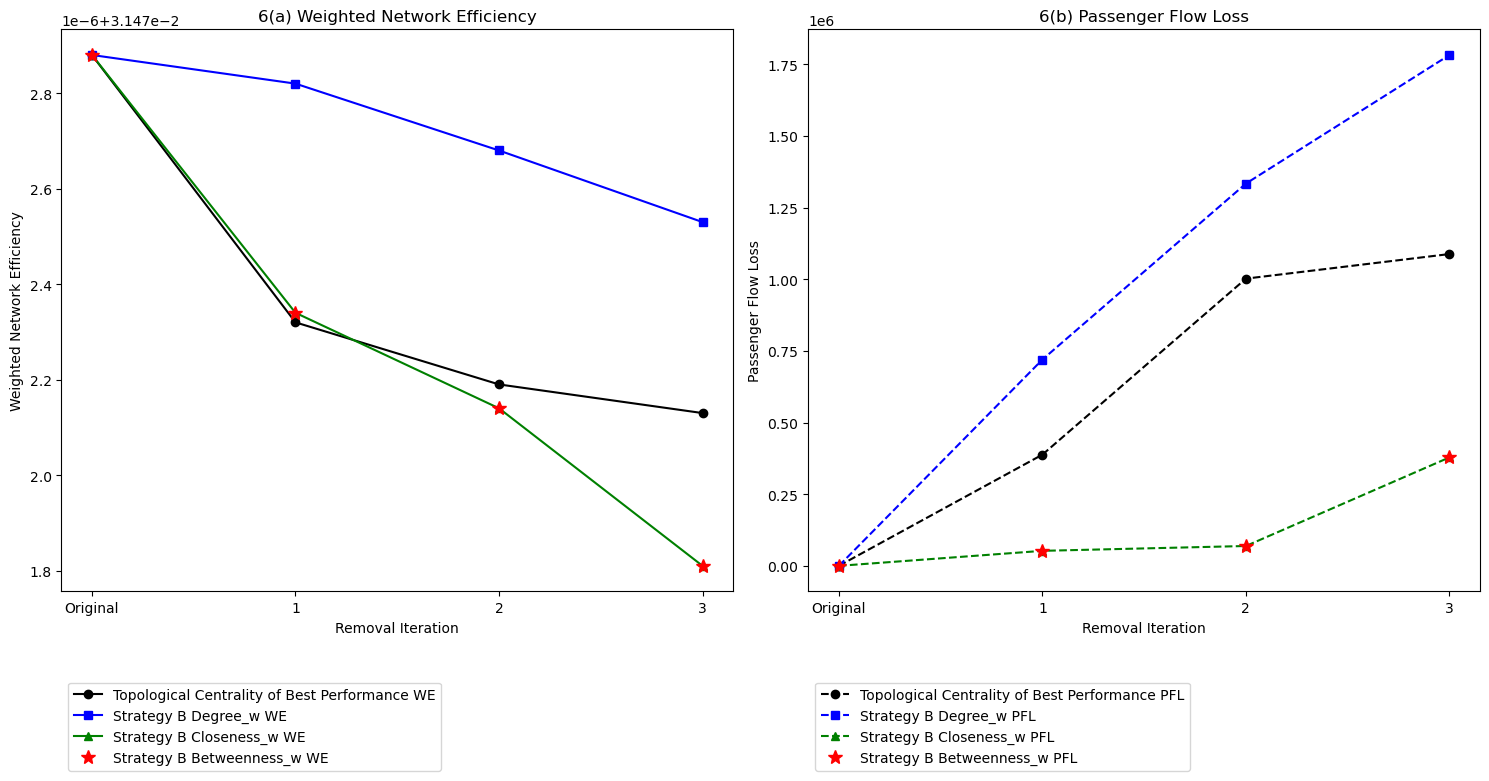

In [78]:
# 示例数据
iterations = ['Original', '1', '2', '3']
efficiency_betweenness = [0.03147288, 0.03147232, 0.03147219, 0.03147213]
efficiency_degree_w = [0.03147288, 0.03147282, 0.03147268, 0.03147253]
efficiency_closeness_w = [0.03147288, 0.03147234, 0.03147214, 0.03147181]
efficiency_betweenness_w = [0.03147288, 0.03147234, 0.03147214, 0.03147181]
passenger_loss_betweenness = [0, 388110.197000, 1002393.341000, 1088187.882000]
passenger_loss_degree_w = [0, 719871.374000, 1334154.518000, 1782939.306000]
passenger_loss_closeness_w = [0, 52403.282000, 69295.536000, 378590.267000]
passenger_loss_betweenness_w = [0, 52403.282000, 69295.536000, 378590.267000]

# 创建图形和子图
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# 子图1 - 加权网络效率
axs[0].plot(iterations, efficiency_betweenness, 'k-o', label='Topological Centrality of Best Performance WE')
axs[0].plot(iterations, efficiency_degree_w, 'b-s', label='Strategy B Degree_w WE')
#axs[0].plot(iterations, efficiency_betweenness_w, 'r-*', label='Weighted Closeness and Betweenness Centrality', markersize=10)
axs[0].plot(iterations, efficiency_closeness_w, 'g-^', label='Strategy B Closeness_w WE')
axs[0].plot(iterations, efficiency_betweenness_w, 'r*', label='Strategy B Betweenness_w WE', linestyle='None', markersize=10) 
axs[0].set_title('6(a) Weighted Network Efficiency')
axs[0].set_xlabel('Removal Iteration')
axs[0].set_ylabel('Weighted Network Efficiency')
axs[0].legend(loc='lower left')

# 子图2 - 客流损失
axs[1].plot(iterations, passenger_loss_betweenness, 'k--o', label='Topological Centrality of Best Performance PFL')
axs[1].plot(iterations, passenger_loss_degree_w, 'b--s', label='Strategy B Degree_w PFL')
axs[1].plot(iterations, passenger_loss_closeness_w, 'g--^', label='Strategy B Closeness_w PFL')
axs[1].plot(iterations, passenger_loss_betweenness_w, 'r*', label='Strategy B Betweenness_w PFL', linestyle='None', markersize=10) 
axs[1].set_title('6(b) Passenger Flow Loss')
axs[1].set_xlabel('Removal Iteration')
axs[1].set_ylabel('Passenger Flow Loss')
axs[1].legend(loc='upper left')

axs[0].legend(loc='upper left', bbox_to_anchor=(0, -0.15))
axs[1].legend(loc='upper left', bbox_to_anchor=(0, -0.15))

plt.tight_layout()
plt.savefig("outputs/W_WE_vs_PFL.png", format='png', dpi=300, bbox_inches='tight')
plt.show()